# Thermal Occupations Redux
## Non-Interacting only
### By Anthony Osborne
#### Based on code from Vincent Martinetto

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh
from numpy import linspace
from numpy import array
import matplotlib.pyplot as plt
from scipy.integrate import simps
import matplotlib.animation as animation
from IPython.display import HTML
#import iDEA
import math
from matplotlib import cm
import scipy
from decimal import Decimal

## Set up
### Definition of Harmonic Oscillator $v_{ext}$ and Fermi Occupation Function

In [3]:
# Fermi Occupation function
def occs(Eis,mu,tau):
    '''
    INPUT:
        tau: Scalar
            the tau value to find the temprature dependent mu for
        mus: scalar
            a guess at a value below the chemical potential for tau
        Eis: Scalar
            Some kind of energy -- AO
    OUTPUT
        F_occs: Scalar
            The Fermi Occupation for mu, tau, Eis
    '''
    F_occs = 1/(1+np.exp((Eis-mu)/tau))
    return F_occs

#Harmonic oscillator external potential
def v_harm(x):
    '''
    INPUT:
        x: ndarray
            Position
    OUTPUT
        harm_ext: Scalar
            harmonic oscillator potential
    '''
    harm_ext = .5*x**2
    return harm_ext

### Plotting Function

#### Regular Single line plot

In [4]:
def plotFunction(firstSet, secSet, a="None", b="None", Ngrid="None", N="None", eigenValues="None",eigenVaectors="None", limits="n",x_lim1="None", x_lim2="None", y_lim1="None", y_lim2="None", xlabel="", ylabel="", title="", ncols=1, thickGraph="n", plotPoint="n", px=0, pfx=0, xplot="n", Function="None", multiplot="None", multi1="None", multi2="None", multi3="None", label1="None", label2="None", label3="None", label4="None"):
        """
        Description: Plot function for notebook
        Current Capabilites: Built to test different functions to make sure they are working as expected 
        Goal: Eventually this will be set up to plot everything in the notebook 
        Note: To adjust the plot you can use matplotlib functions before this function call. Example:
            plt.title("A plot")
            plt.ylim(0,5)
            plt.xlim(-1,2)
            plotFunction(lambda x: x**2, a, b, ...)
        :param firstSet
        :param secSet
        :param a="None"
        :param b="None"
        :param Ngrid="None"
        :param N="None"
        :param eigenValues="None"
        :param eigenVaectors="None"
        :param limits="n"
        :param x_lim1: The left x axis limit            default: None (no limits)
        :param x_lim2: The right x axis limit           default: None (no limits)
        :param y_lim1: The bottom y axis limit          default: None (no limits)
        :param y_lim1: The top y axis limit             default: None (no limits)      
        :param xlabel: Label for x axis                 default: blank
        :param ylabel: Label for y axis                 default: blank
        :param title:  Title for plot                   default: blank        
        :param nocls: the number of columns for figure  default: 1 Currenlty only works for 1 column needs updating for >1
        :param thickGraph: determines axes thickness    default: no Ideal for code. For posters use yes
        :param plotPoint="n"
        :param px=0
        :param pfx=0
        :param xplot="n"
        :param Function="None"
        :param multiplot="None"
        :param multi1="None"
        :param multi2="None"
        :param multi3="None"
        :param label1="None"
        :param label2="None"
        :param label3="None"
        :param label4="None"
        :param a: left interval
        :param b: right interval
        #-------> Not used in current build but here for the future use
        :param N: Number of basis functions
        :param eigenValues: Eigenvalues
        :param eigenVectors: Eigenvector matrix of size N x len(eigenValues)
        """
        if ncols >1: #-------> This will eventually be changed but for now serves as an error message
                print("Error Function is currently built to handle only one column")
                print("Quitting Plot Function. Please adjust parameters and try again")
                return 
        #---------------> Plot
        fig, ax = plt.subplots(ncols, dpi=100) #sharex=True, sharey=True, dpi=200)
        #---------------> Data
        #-------> Plotting more than one line
        if multiplot == "1":
                ax.plot(firstSet, secSet, color='tab:blue', label=label1)
                ax.plot(firstSet, multi1, color='tab:orange', label=label2)
                ax.legend()
        if multiplot == "2":
                ax.plot(firstSet, secSet, color='tab:blue', label=label1)
                ax.plot(firstSet, multi1, color='tab:orange', label=label2)
                ax.plot(firstSet, multi2, color='tab:green', linestyle='dashed', label=label3)
                ax.legend()
        if multiplot == "3":
                ax.plot(firstSet, secSet, color='tab:blue',label=label1)
                ax.plot(firstSet, multi1, color='tab:orange',label=label2)
                ax.plot(firstSet, multi2, color='tab:green',label=label3)
                ax.plot(firstSet, multi3, color='tab:red',label=label4)
        #-------> Plotting a function of x
        if xplot =="y":
                x = linspace(a, b, Ngrid)
                ax.plot(x, Function(x), linewidth=1)
        else:
                ax.plot(firstSet, secSet, linewidth=1)
        if thickGraph =="y":
                ax.plot(firstSet, secSet, linewidth=3,)
        #-------> Plotting just one point
        if plotPoint =="y":
                ax.plot(px, pfx, 'bo')
                #ax.annotate(px, pfx)
        #---------------> Formatting
        if limits == "y":
                ax.set_ylim(y_lim1, y_lim2)
                ax.set_xlim(x_lim1, x_lim2)

        #ax.set(adjustable='box', aspect='equal')
        ax.set_xlabel(xlabel)#, fontsize=20)
        ax.set_ylabel(ylabel)#, fontsize=20)
        fig.suptitle(title)#, fontsize=20)
        fig.tight_layout()
        #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
        if thickGraph == "y":
                plt.rcParams["axes.edgecolor"] = "black"
                plt.rcParams["axes.linewidth"] = 2.0
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                ax.xaxis.set_tick_params(width=2)
                ax.yaxis.set_tick_params(width=2)

#### Multiple Lines on one plot -------> Going to become animate plot function

In [5]:
def Multiplot(multi1, multi2, multi3, a, b, Ngrid, x_lim1=0, x_lim2=10, y_lim1=-1, y_lim2=10, xlabel="", ylabel="", title="", ncols=1, thickGraph="n", plotPoint="n", px=0, pfx=0):
        """
        Description: Plot function for notebook
        Current Capabilites: Built to test different functions to make sure they are working as expected 
        Goal: Eventually this will be set up to plot everything in the notebook 
        Note: To adjust the plot you can use matplotlib functions before this function call. Example:
            plt.title("A plot")
            plt.ylim(0,5)
            plt.xlim(-1,2)
            plotFunction(lambda x: x**2, a, b, ...)

        :param potentialfunction: V(x)
        :param a: left interval
        :param b: right interval
        :param x_lim1: The left x axis limit            default: 0
        :param x_lim2: The right x axis limit           default: 10
        :param y_lim1: The bottom y axis limit          default: -1 
        :param y_lim1: The top y axis limit             default: 10
        :param xlabel: Label for x axis                 default: blank
        :param ylabel: Label for y axis                 default: blank
        :param title:  Title for plot                   default: blank
        :param nocls: the number of columns for figure  default: 1 Currenlty only works for 1 column needs updating for >1
        :param thickGraph: determines axes thickness    default: no Ideal for code. For posters use yes
        #------->
        """
        if ncols >1:
                raise Exception("Not Implemented for more than 1 column, Quitting Plot Function. Please adjust parameters and try again") 
        x = linspace(a, b, Ngrid)
        #---------------> Plot
        fig, ax = plt.subplots(ncols, dpi=100) #sharex=True, sharey=True, dpi=200)
        #---------------> Data
        ax.plot(multi1, multi2)
        ax.plot(multi1, multi3)
        #---------------> Formatting
        ax.set_ylim(y_lim1, y_lim2)
        ax.set_xlim(x_lim1, x_lim2)

        #ax.set(adjustable='box', aspect='equal')
        ax.set_xlabel(xlabel, fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
        fig.suptitle(title, fontsize=20)
        fig.tight_layout()
        #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
        if thickGraph == "y":
                plt.rcParams["axes.edgecolor"] = "black"
                plt.rcParams["axes.linewidth"] = 2.0
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                ax.xaxis.set_tick_params(width=2)
                ax.yaxis.set_tick_params(width=2)

#### Plot Functions Test

##### Regular Plot test

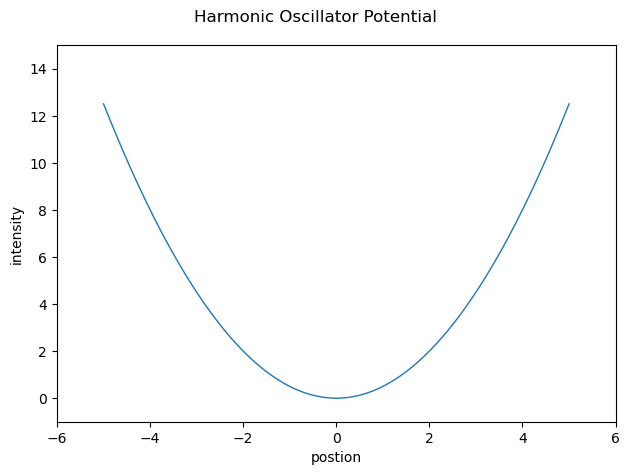

In [6]:
junk1 = linspace(-5, 5, 401) #-------> Literally just a linspace that does not get used but I couldnt in good faith make the plot function only have **KWARGS
plotFunction(junk1, junk1, a=-5, b=5, Ngrid=401, limits="y", x_lim1=-6, x_lim2=6, y_lim1=-1, y_lim2=15, xlabel="postion", ylabel="intensity" ,title="Harmonic Oscillator Potential", ncols=1, xplot="y", Function=v_harm)

##### Double Plot test

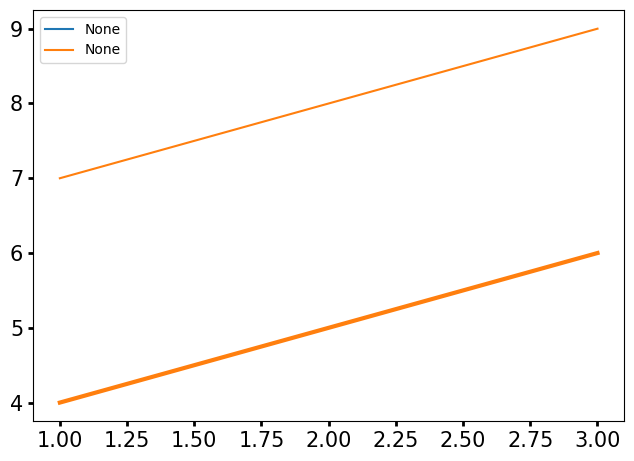

In [7]:
a, b, Ngrid = -100, 100, 100
test1 = [1, 2, 3]
test2 = [4, 5, 6]
test3 = [7, 8, 9]
plotFunction(test1, test2, multiplot="1", multi1=test3, thickGraph="y")

### Secant method for root finding

In [8]:
def secant(x0,x1,fx0,fx1):
    '''
    the update process for the secant method
    '''
    return (x0*fx1-fx0*x1)/(fx1-fx0)

def secant_method(x0,x1,func,criterion=1e-6,max_iter=100):
    '''
    Description: Based on the secant method page on wikipedia
    takes the first two guesses at the correct root and a defined
    function then run the secant method to find the root.
    INPUT:
        x0: Scalar
            First guess at root value
        x1: scalar
            Second guess at root value
        func: Scalar
            Function to find root of
    OUTPUT
        x1: Scalar
            Root value
        fx1: Scalar
            function evaluated at root value            
    '''
    
    i = 0
    
    fx0 = func(x0)
    fx1 = func(x1)
    conv = abs(min([fx0,fx1]))
    
    while conv > criterion:
        xt = secant(x0,x1,fx0,fx1)
        
        fx0 = fx1
        x0 = x1
        x1 = xt
        fx1 = func(x1)
        
        conv = abs(fx1)
        
        if i > max_iter:
            break
        i += 1
        
    return x1,fx1

#### Secant Method test

Point coordinates are: -1.7080391071060965e-07 , -1.7080391071060798e-07


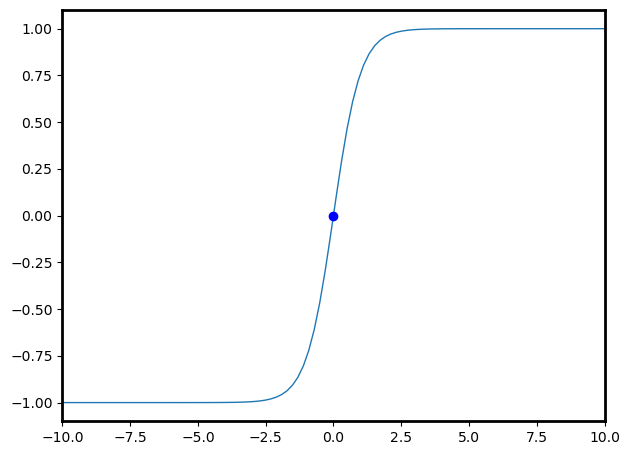

In [9]:
x0,fx0 = secant_method(-2.5,3,np.tanh)
print("Point coordinates are:", x0,",", fx0)
plotFunction(x0, fx0, -10, 10, 100, xplot="y", Function=np.tanh, limits="y", y_lim1=-1.1, y_lim2=1.1, x_lim1=-10, x_lim2=10, plotPoint="y", px=x0, pfx=fx0)

### Calculating Harmonic Oscillator or P.I.B. Eigenstates and Eigenvectors

In [10]:
def Eigen_Solver(Sys, a, b, Nx, nk):
    '''
    Description: Solves for the eigenvalues and eigenvectors of either the H.O. or P.I.B.
    Current Capabilities: Does all that it is desired
    Goal: 
    Note: Need to define nk, pretty sure all values are correct
    INPUT:
        Sys: String
            Determines if using Harmonic Oscillator or P.I.B. 
        a: Scalar
            Left limit of linespace
        b: scalar
            Right limit of linespace
        Nx: scalar
            Number of points in linespace
        nk: scalar
            Number of kpoints??? Not sure what this is
    OUTPUT
        Vals: ndarray
            Eigenvalues
        Vecs: ndarray
            Eigenvectors
    '''
    #-------> Set-Up
    x = linspace(a, b, Nx)
    if Sys == "Harm":
        v_ext = v_harm(x)
    if Sys == "PIB":
        v_ext = np.zeros(Nx)
    #-------> Diagonalization 
    dx = x[1]-x[0]
    diag = (np.ones(Nx)/dx**2)
    #print(diag)
    diags = array([(v_ext+diag), (diag/2), (diag/2)])
    #-------> Calculating Hamiltonian
    H = spa.dia_matrix((diags,[0,-1,1]),shape=(Nx,Nx))
    vals, vecs = eigsh(H,which='SA',k=nk)
    vec_sum = np.trapz(vecs[:,0]**2,x)
    norm = np.sqrt(1/vec_sum)
    vecs = vecs*norm
    return vals, vecs, x

#### Solver Function test

In [11]:
a, b, Nx, nk = -5, 5, 401, 100
vals, vecs, x = Eigen_Solver("Harm", a, b, Nx, nk)
#print(vals)
#print(vecs)

### Show that the plot of particle number over $\mu$ is sigmoidal for a fixed $\tau$

The sigmoid can be shifted such that the single root of the sigmoid is the number of particles. Then we can use a root finding method to mind the proper chemical potnetial, mu, at temprature, tau, such that the number of particles in the system is the same. I have a VERY rough understanding of why we are doing this. 

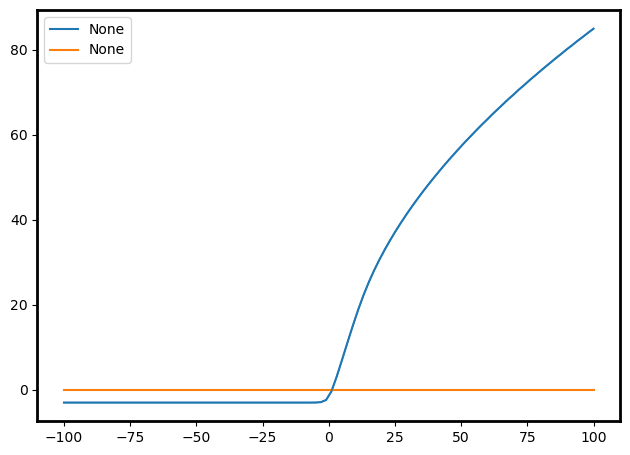

In [12]:
tau = 1
mus = linspace(-100,100,100)
Nes = np.empty(len(mus))
for i,mu in enumerate(mus):
    fs = occs(vals,mu,tau)
    dens = np.zeros(len(x))
    for j,f in enumerate(fs):
        dens += f*2*vecs[:,j]**2
    Nes[i] = np.trapz(dens,x)
a, b, Ngrid = -100, 100, 100
#print(mus)
#print(Nes-3)
#print(np.zeros(len(mus)))

#plt.plot(mus,Nes-3)
#-------> Tried to use my plot function it broke plotFunction(mus, -100, 100, 100, multiplot="1", multi2=Nes)
#Multiplot(mus, Nes-3, np.zeros(len(mus)), a, b, Ngrid, x_lim1=a-10, x_lim2=b+10, y_lim1=-10, y_lim2=90)
plotFunction(mus, Nes-3, multiplot="1", multi1=np.zeros(len(mus)), x_lim1=a-10, x_lim2=b+10, y_lim1=-10, y_lim2=90)
#plt.plot(mus,np.zeros(len(mus)))


### Define the function to calculate particle number for a a given $\mu$ and $\tau$ for a set of eigenvectors and values

In [13]:
def dens_function(fs,vecs,x):
    '''
    Description: Not even used
    INPUT:
        fs: ndarray
            
        vecs: ndarray
            
        x: ndarray
            
    OUTPUT
        Dens: ndarray
            The density for the system
    '''
    dens = np.zeros(len(x))
    for i,f in enumerate(fs):
        dens+=2*f*vecs[:,i]**2
    return dens

def particle_number_function(mu,tau,vals,vecs,x):
    '''
    Description: Determine the Unshifted particle number
    INPUT:
        mu: Scalar (float)
            chemical potential
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
    OUTPUT
        Ne: Scalar (float)
            The unshifted particle number
    '''
    fs = occs(vals,mu,tau)
    dens = np.zeros(len(x))
    for i,f in enumerate(fs):
        dens += 2*f*vecs[:,j]**2
    Ne = np.trapz(dens,x)
    return Ne

def particle_number_shifter(tau,vals,vecs,x,target_Ne): 
    
    '''
    Old title: particle_number_function_function

    Description: Determines the Shifted particle number
    INPUT:
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
        target_Ne: Scalar (int)
            The desired particle number
    OUTPUT
        particle_number_Shift: Scalar (float)
            The Shifted particle number
    '''

    def particle_number_Shift(mu):
        
        fs = occs(vals,mu,tau)
        dens = np.zeros(len(x))
        for i,f in enumerate(fs):
            dens += 2*f*vecs[:,j]**2
        Ne = np.trapz(dens,x)
        
        return Ne - target_Ne
    
    return particle_number_Shift

In [14]:
taus = np.linspace(1,100,1001)
dtau = taus[1]-taus[0]
mus = np.empty(len(taus))
Nes = np.empty(len(taus))
mu0s = np.empty(len(taus))
mu1s= np.empty(len(taus))
mu_upper = np.empty(len(taus))

mu0 = 1
mu1 = 5

for i,tau in enumerate(taus):
    mu_upper[i] = mu1
    
    func = particle_number_shifter(tau,vals,vecs,x,3)
    mu1,fx0 = secant_method(mu0,mu1,func,criterion=1e-10)
    
    mu0s[i] = mu0
    mu1s[i] = mu1
    
    mus[i] = mu1
    Nes[i] = particle_number_function(mu1,tau,vals,vecs,x)
    
    mu0 = mu1-(dtau+(.1*dtau*i))

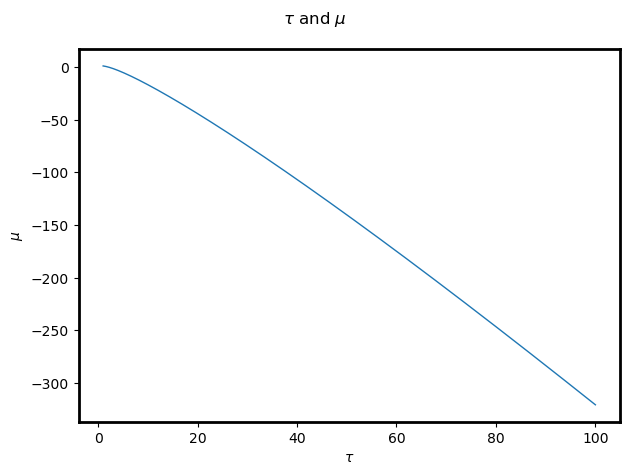

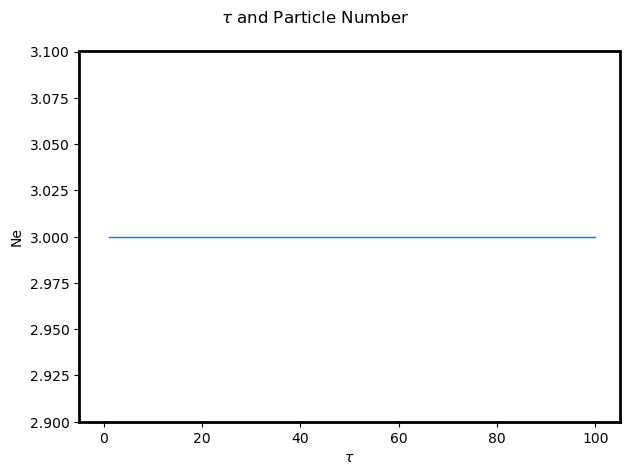

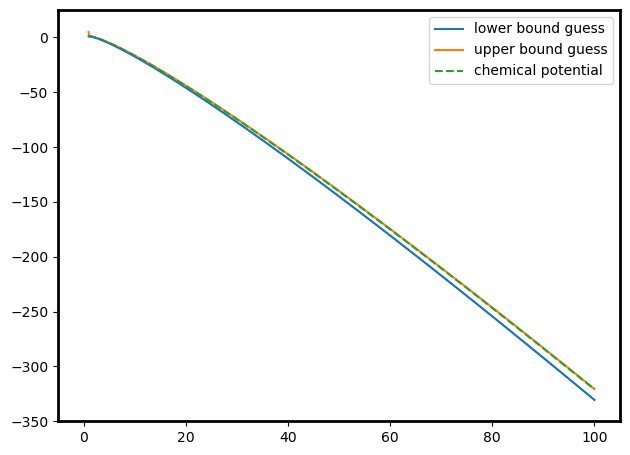

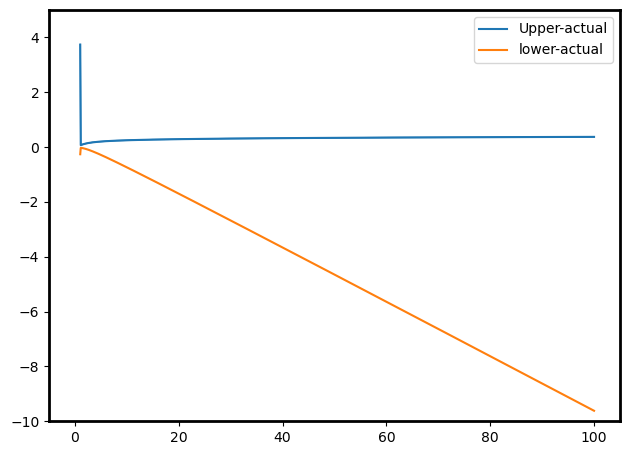

In [15]:
plotFunction(taus, mus, title="$\\tau$ and $\\mu$", xlabel='$\\tau$', ylabel='$\\mu$')
plotFunction(taus, Nes, title="$\\tau$ and Particle Number", xlabel='$\\tau$', ylabel='Ne', limits="y", y_lim1=2.900, y_lim2=3.100, x_lim1=-5, x_lim2=105)
plotFunction(taus, mu0s, multiplot="2", multi1=mu_upper, multi2=mu1s, label1="lower bound guess", label2="upper bound guess", label3="chemical potential", limits="y", y_lim1=-350, y_lim2=25, x_lim1=-5, x_lim2=105)
plotFunction(taus, (mu_upper-mu1s), multiplot="1", multi1=(mu0s-mu1s), label1="Upper-actual", label2="lower-actual", limits="y", y_lim1=-10, y_lim2=5, x_lim1=-5, x_lim2=105)

## Implement a search over a range of $\tau$ that returns $\mu$ for each value of $\tau$ to conserve a number of particles
### need a search function for single particle functions using fermi statitics

In [16]:
def tau_search(taus,mu0,mu1,vals,vecs,x,Ne,criterion=1e-10):
    '''
    INPUT:
        taus: vector, len=n
            the tau value to find the temperature dependent mu for
        mu0: scalar
            a guess at a value below the chemical potential for taus[0]
        mu1: scalar
            a guess for a value above the chemical potential for taus[0]
        vals: vector, len=k
            The eigenvalues of the eigenvectors that the mus should be computed for
        vecs: matrix, size=(Nx,k)
            The eigenvectors of the system that mu should be found for for each tau.
            Nx is the number of grid points.
            k is the number of states inclueded in the calculation.
        x: vector, len=Nx
            The grid that the eigenvectors were computed on.
        Ne: scalar
            The fixed number of electrons in the system
        criterion: scalar
            The convergence criterion that the secant method should look to obtain
    OUTPUT
        mus: vector, len=n
            the chemical potnetial at each temp tau to conserve the number of particles in the system
    '''
    dtau = taus[1]-taus[0]
    mus = np.empty(len(taus))

    for i,tau in enumerate(taus):
        
        func = particle_number_shifter(tau,vals,vecs,x,Ne)
        mu1,fx0 = secant_method(mu0,mu1,func,criterion=criterion)
    
        mus[i] = mu1
    
        mu0 = mu1-(dtau+(.1*dtau*i))
        
    return mus